- Author: Peter Riesebos
- Purpose: Script used to look up significant eQTLs from one file (TopEffects) in another (AllEffects) to check for overlap and flipped alleles.
- Input: mbQTL format summary stats files (TopEffets and AllEffects files) from different datasets.
- Output: summary stats of found overlap and flipped alleles

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing
import dask.dataframe as dd  # Ensure Dask is imported
import logging
from dask.dataframe import read_csv
import os
import glob

In [33]:
# Configure logging
logging.basicConfig(level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    handlers=[logging.StreamHandler()])

# Function to create a unique ID for comparison
def create_unique_id(gene, gene_chr, snp_pos, snp_alleles, flip=False):
    if flip:
        alleles = snp_alleles.split('/')
        flipped_alleles = f"{alleles[1]}/{alleles[0]}"
        return f"{gene}:{gene_chr}:{snp_pos}:{flipped_alleles}"
    else:
        return f"{gene}:{gene_chr}:{snp_pos}:{snp_alleles}"

# Function to compare files (this function now returns the matching rows)
def compare_files(chromosome_file, combined_df):
    logging.info(f"Processing file: {chromosome_file}")
    
    # Use memory-mapped files for chromosome data using Dask
    chrom_df = dd.read_csv(chromosome_file, 
                           dtype={'Gene': str, 'GeneChr': str, 'SNPPos': int, 'SNPAlleles': str, 'MetaPZ': float}, 
                           sep='\t', blocksize='64MB', assume_missing=True)
    
    # Create unique combination of relevant columns for the chromosome file
    chrom_df['UniqueID'] = chrom_df.apply(lambda row: create_unique_id(
        row['Gene'], row['GeneChr'], row['SNPPos'], row['SNPAlleles']), axis=1, meta=('x', 'str'))

    # Add a new column 'Flipped' and set to False by default
    chrom_df['Flipped'] = False

    # Rename MetaPZ column in the chromosome DataFrame to avoid conflicts during merge
    chrom_df = chrom_df.rename(columns={"MetaPZ": "MetaPZ_chrom"})

    # Create indexes on `UniqueID` and `UniqueID_Flipped` columns for the combined DataFrame
    combined_df.set_index('UniqueID', inplace=True)
    combined_df_flipped = combined_df.set_index('UniqueID_Flipped')

    total_exact_matches = 0
    total_flipped_matches = 0
    matching_rows_list = []

    # Iterate through the chromosome file in chunks
    for chunk in chrom_df.partitions:  # Iterate over Dask partitions
        chunk_df = chunk.compute()  # Convert partition to pandas DataFrame

        # Log the size of the current chunk
        logging.info(f"Processing chunk of size: {len(chunk_df)}")

        # Vectorized matching for exact and flipped matches
        exact_match = chunk_df[chunk_df['UniqueID'].isin(combined_df.index)]
        flipped_match = chunk_df[chunk_df['UniqueID'].isin(combined_df_flipped.index)]

        # Update match counts
        total_exact_matches += len(exact_match)
        total_flipped_matches += len(flipped_match)

        # Mark flipped matches
        if not flipped_match.empty:
            flipped_match['Flipped'] = True

        # Merge the exact matches with the combined_df on the 'UniqueID' and add the MetaPZ from the combined_df
        if not exact_match.empty:
            exact_match = exact_match.merge(combined_df[['MetaPZ']], left_on='UniqueID', right_index=True, suffixes=('_chrom', '_combined'))

        # Merge the flipped matches with the combined_df_flipped on 'UniqueID_Flipped' and add the MetaPZ from the combined_df
        if not flipped_match.empty:
            flipped_match = flipped_match.merge(combined_df_flipped[['MetaPZ']], left_on='UniqueID', right_index=True, suffixes=('_chrom', '_combined'))

        # Combine exact and flipped matches into a single DataFrame
        matching_rows = pd.concat([exact_match, flipped_match])

        # Append matching rows to the list
        if not matching_rows.empty:
            matching_rows_list.append(matching_rows)

    logging.info(f"File processed: {chromosome_file}, Total exact matches: {total_exact_matches}, Total flipped matches: {total_flipped_matches}")
    
    # Return concatenated matching rows from this file
    if matching_rows_list:
        return pd.concat(matching_rows_list)
    else:
        return pd.DataFrame()  # Return empty DataFrame if no matches found

# Function to process chromosome files in parallel
def process_chromosome_files(combined_file, chromosome_dir, output_file):
    logging.info(f"Starting to process combined file: {combined_file}")
    
    # Read in the combined summary statistics file
    combined_df = pd.read_csv(combined_file, sep='\t')

    # Create unique IDs for the combined dataset
    combined_df['UniqueID'] = combined_df.apply(lambda row: create_unique_id(
        row['Gene'], row['GeneChr'], row['SNPPos'], row['SNPAlleles']), axis=1)
    
    combined_df['UniqueID_Flipped'] = combined_df.apply(lambda row: create_unique_id(
        row['Gene'], row['GeneChr'], row['SNPPos'], row['SNPAlleles'], flip=True), axis=1)

    logging.info("Finished processing the combined file and generating unique IDs.")
    
    # Use multiprocessing to process chromosome files in parallel
    pool = multiprocessing.Pool()
    chromosome_files = [f for f in os.listdir(chromosome_dir) if f.endswith('AllEffects.txt.gz')]
    
    if not chromosome_files:
        logging.warning(f"No files to process in directory: {chromosome_dir}")
        return
    
    args_list = [(os.path.join(chromosome_dir, chromosome_file), combined_df) 
                 for chromosome_file in chromosome_files]
    
    logging.info(f"Processing {len(chromosome_files)} chromosome files in parallel.")
    
    # Run the comparison in parallel and collect the results
    results = pool.starmap(compare_files, args_list)
    pool.close()
    pool.join()

    # Filter out empty dataframes and concatenate the rest
    valid_results = [df for df in results if not df.empty]
    
    if valid_results:
        logging.info("Valid data found, concatenating results...")
        merged_df = pd.concat(valid_results)
        merged_df.to_csv(output_file, sep='\t', index=False)
    else:
        logging.warning("No matching data found across any chromosome files.")

    logging.info("Finished processing all chromosome files.")


In [34]:
gtex_all = '/groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/GTEx/mbqtl_output_gtex_exp_fixed'
gtex_top = '/groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/GTEx/mbqtl_output_gtex_exp_fixed/merged_topeffects_final.txt'
werna_all = '/groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/Werna/qtl/eqtl/output_exp_fixed'
werna_top = '/groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/Werna/qtl/eqtl/output_exp_fixed/merged_topeffects_final.txt'
pub_rna_all = '/groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/pub_rna/mbqtl_output_pub_rna_exp_fixed'
pub_rna_top = '/groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/pub_rna/mbqtl_output_pub_rna_exp_fixed/merged_topeffects_final.txt'

Naming scheme:  
Combined file = TopEffects file  
chromosome_dir = AllEffects files  
output_file = found top effects in another studies AllEffects, e.g. pub_rna_werna_overlap.txt   
                   (where pub_rna is the Combined file and werna is the all effects file)  

process_chromosome_files(combined_file, chromosome_dir, output_file) > process_chromosome_files(pub_rna_top, werna_all, output_file)

In [41]:
output_file = '/groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/intersect/pub_rna_werna_overlap.txt'

# Process all chromosome files and merge into one output
process_chromosome_files(pub_rna_top, werna_all, output_file)

2024-09-25 09:53:11,462 - INFO - Starting to process combined file: /groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/pub_rna/mbqtl_output_pub_rna_exp_fixed/merged_topeffects_final.txt
2024-09-25 09:53:11,552 - INFO - Finished processing the combined file and generating unique IDs.
2024-09-25 09:53:12,252 - INFO - Processing 22 chromosome files in parallel.
2024-09-25 09:53:12,284 - INFO - Processing file: /groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/Werna/qtl/eqtl/output_exp_fixed/__19-AllEffects.txt.gz
/groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/users/umcg-priesebos/miniforge3/lib/python3.12/site-packages/dask/dataframe/io/csv.py:555: UserWarning: Warning gzip compression does not support breaking apart files
Please ensure that each individual file can fit in memory and
use the keyword ``blocksize=None to remove this message``
Setting ``blocksize=None``
  warn(
2024-09-25 09:53:12,297 - INFO - Processing fil

In [35]:
output_file = '/groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/intersect/werna_pub_rna_overlap.txt'

# Process all chromosome files and merge into one output
process_chromosome_files(werna_top, pub_rna_all, output_file)

2024-09-25 09:49:05,635 - INFO - Starting to process combined file: /groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/Werna/qtl/eqtl/output_exp_fixed/merged_topeffects_final.txt
2024-09-25 09:49:05,666 - INFO - Finished processing the combined file and generating unique IDs.
2024-09-25 09:49:06,380 - INFO - Processing 22 chromosome files in parallel.
2024-09-25 09:49:06,399 - INFO - Processing file: /groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/pub_rna/mbqtl_output_pub_rna_exp_fixed/pub_rna_chr10-AllEffects.txt.gz
2024-09-25 09:49:06,401 - INFO - Processing file: /groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/pub_rna/mbqtl_output_pub_rna_exp_fixed/pub_rna_chr17-AllEffects.txt.gz
2024-09-25 09:49:06,402 - INFO - Processing file: /groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/pub_rna/mbqtl_output_pub_rna_exp_fixed/pub_rna_chr5-AllEffects.txt.gz

In [42]:
output_file = '/groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/intersect/gtex_pub_rna_overlap.txt'

# Process all chromosome files and merge into one output
process_chromosome_files(gtex_top, pub_rna_all, output_file)

2024-09-25 09:55:27,135 - INFO - Starting to process combined file: /groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/GTEx/mbqtl_output_gtex_exp_fixed/merged_topeffects_final.txt
2024-09-25 09:55:27,287 - INFO - Finished processing the combined file and generating unique IDs.
2024-09-25 09:55:27,951 - INFO - Processing 22 chromosome files in parallel.
2024-09-25 09:55:27,994 - INFO - Processing file: /groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/pub_rna/mbqtl_output_pub_rna_exp_fixed/pub_rna_chr10-AllEffects.txt.gz
/groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/users/umcg-priesebos/miniforge3/lib/python3.12/site-packages/dask/dataframe/io/csv.py:555: UserWarning: Warning gzip compression does not support breaking apart files
Please ensure that each individual file can fit in memory and
use the keyword ``blocksize=None to remove this message``
Setting ``blocksize=None``
  warn(
2024-09-25 09:55:28,009 - INFO - Proc

In [43]:
output_file = '/groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/intersect/pub_rna_gtex_overlap.txt'

# Process all chromosome files and merge into one output
process_chromosome_files(pub_rna_top, gtex_all, output_file)

2024-09-25 09:56:44,736 - INFO - Starting to process combined file: /groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/pub_rna/mbqtl_output_pub_rna_exp_fixed/merged_topeffects_final.txt
2024-09-25 09:56:44,817 - INFO - Finished processing the combined file and generating unique IDs.
2024-09-25 09:56:45,475 - INFO - Processing 22 chromosome files in parallel.
2024-09-25 09:56:45,510 - INFO - Processing file: /groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/GTEx/mbqtl_output_gtex_exp_fixed/gtex_chr10-AllEffects.txt.gz
/groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/users/umcg-priesebos/miniforge3/lib/python3.12/site-packages/dask/dataframe/io/csv.py:555: UserWarning: Warning gzip compression does not support breaking apart files
Please ensure that each individual file can fit in memory and
use the keyword ``blocksize=None to remove this message``
Setting ``blocksize=None``
  warn(
2024-09-25 09:56:45,524 - INFO - Process

In [44]:
output_file = '/groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/intersect/werna_gtex_overlap.txt'

# Process all chromosome files and merge into one output
process_chromosome_files(werna_top, gtex_all, output_file)

2024-09-25 09:58:17,635 - INFO - Starting to process combined file: /groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/Werna/qtl/eqtl/output_exp_fixed/merged_topeffects_final.txt
2024-09-25 09:58:17,661 - INFO - Finished processing the combined file and generating unique IDs.
2024-09-25 09:58:18,334 - INFO - Processing 22 chromosome files in parallel.
2024-09-25 09:58:18,348 - INFO - Processing file: /groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/GTEx/mbqtl_output_gtex_exp_fixed/gtex_chr10-AllEffects.txt.gz
/groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/users/umcg-priesebos/miniforge3/lib/python3.12/site-packages/dask/dataframe/io/csv.py:555: UserWarning: Warning gzip compression does not support breaking apart files
Please ensure that each individual file can fit in memory and
use the keyword ``blocksize=None to remove this message``
Setting ``blocksize=None``
  warn(
2024-09-25 09:58:18,355 - INFO - Processing fil

In [25]:
output_file = '/groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/intersect/gtex_werna_overlap.txt'

# Process all chromosome files and merge into one output
process_chromosome_files(gtex_top, werna_all, output_file)

2024-09-25 09:59:50,903 - INFO - Starting to process combined file: /groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/GTEx/mbqtl_output_gtex_exp_fixed/merged_topeffects_final.txt
2024-09-25 09:59:51,052 - INFO - Finished processing the combined file and generating unique IDs.
2024-09-25 09:59:51,721 - INFO - Processing 22 chromosome files in parallel.
2024-09-25 09:59:51,764 - INFO - Processing file: /groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/Werna/qtl/eqtl/output_exp_fixed/__19-AllEffects.txt.gz
/groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/users/umcg-priesebos/miniforge3/lib/python3.12/site-packages/dask/dataframe/io/csv.py:555: UserWarning: Warning gzip compression does not support breaking apart files
Please ensure that each individual file can fit in memory and
use the keyword ``blocksize=None to remove this message``
Setting ``blocksize=None``
  warn(
2024-09-25 09:59:51,780 - INFO - Processing file: /gr

In [26]:
output_file = '/groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/intersect/gtex_gtex_overlap.txt'

# Process all chromosome files and merge into one output
process_chromosome_files(gtex_top, gtex_all, output_file)

2024-09-24 12:22:45,673 - INFO - Starting to process combined file: /groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/GTEx/mbqtl_output_gtex_no_version/merged_topeffects_final.txt
2024-09-24 12:22:45,835 - INFO - Finished processing the combined file and generating unique IDs.
2024-09-24 12:22:46,569 - INFO - Processing 22 chromosome files in parallel.
2024-09-24 12:22:46,617 - INFO - Processing file: /groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/GTEx/mbqtl_output_gtex_no_version/gtex_no_ver_chr22-AllEffects.txt.gz
/groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/users/umcg-priesebos/miniforge3/lib/python3.12/site-packages/dask/dataframe/io/csv.py:555: UserWarning: Warning gzip compression does not support breaking apart files
Please ensure that each individual file can fit in memory and
use the keyword ``blocksize=None to remove this message``
Setting ``blocksize=None``
  warn(
2024-09-24 12:22:46,635 - INFO - Proc

In [27]:
output_file = '/groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/intersect/pub_rna_pub_rna_overlap.txt'

# Process all chromosome files and merge into one output
process_chromosome_files(pub_rna_top, pub_rna_all, output_file)

2024-09-24 12:24:15,230 - INFO - Starting to process combined file: /groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/pub_rna/mbqtl_output_pub_rna_no_version/merged_topeffects_final.txt
2024-09-24 12:24:15,308 - INFO - Finished processing the combined file and generating unique IDs.
2024-09-24 12:24:15,977 - INFO - Processing 22 chromosome files in parallel.
2024-09-24 12:24:16,015 - INFO - Processing file: /groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/pub_rna/mbqtl_output_pub_rna_no_version/pub_rna_no_ver_chr20-AllEffects.txt.gz
2024-09-24 12:24:16,020 - INFO - Processing file: /groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/pub_rna/mbqtl_output_pub_rna_no_version/pub_rna_no_ver_chr13-AllEffects.txt.gz
/groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/users/umcg-priesebos/miniforge3/lib/python3.12/site-packages/dask/dataframe/io/csv.py:555: UserWarning: Warning gzip compression do

## Old stuff

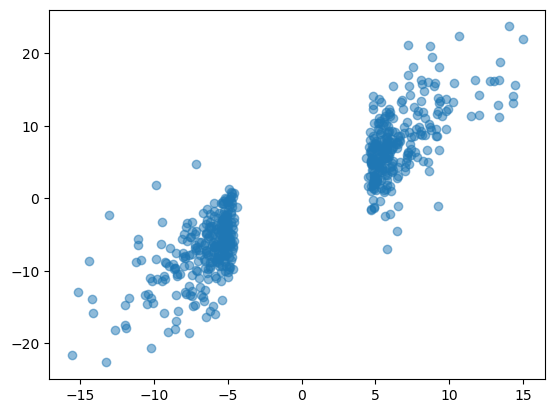

In [40]:
test = pd.read_csv("/groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/intersect/werna_pub_rna_overlap.txt", sep='\t')
test2 = test[["Gene","GeneChr", "SNP", "SNPAlleles", "MetaPZ", "MetaPZ_chrom"]].sort_values(by="GeneChr")
# test2["MetaPZ_combined"].value_counts()
test2
plt.scatter(test2.MetaPZ, test2.MetaPZ_chrom, alpha=0.5)

In [19]:
chr1_gtex = pd.read_csv("/groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/gtex_colon_small_chr1-AllEffects.txt", sep='\t')

In [23]:
def merge_txt_files_to_dataframe(directory_path):
    file_pattern = os.path.join(directory_path, "gtex_colon_small*.txt")
    txt_files = glob.glob(file_pattern)
    
    if not txt_files:
        raise FileNotFoundError(f"No .txt files found in the directory: {directory_path}")
    
    dataframes = []
    
    for file in txt_files:
        try:
            df = pd.read_csv(file, sep='\t')  # Assuming the files are tab-separated
            dataframes.append(df)
        except Exception as e:
            print(f"Error reading {file}: {e}")
    
    if dataframes:
        merged_df = pd.concat(dataframes, ignore_index=True)
    else:
        raise ValueError("No data could be loaded from the .txt files.")
    
    return merged_df

directory_path = '/groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/intersect/'
merged_df = merge_txt_files_to_dataframe(directory_path)

# To check the result
merged_df

,Gene,GeneChr,GenePos,GeneStrand,GeneSymbol,SNP,SNPChr,SNPPos,SNPAlleles,SNPEffectAllele,...,MetaPZ,MetaBeta,MetaSE,MetaI2,NrDatasets,DatasetCorrelationCoefficients(GTEx_Colon_Transverse;GTEx_Small_Intestine),DatasetZScores(GTEx_Colon_Transverse;GTEx_Small_Intestine),DatasetSampleSizes(GTEx_Colon_Transverse;GTEx_Small_Intestine),UniqueID,Flipped
0,ENSG00000273321,18,24402153.0,+,ENSG00000273321.1,rs1245472469,18.0,23468293,CT/C,C,...,1.013194,0.105406,0.104034,0.000000,2.0,0.05651;-0.001044,1.073812;-0.006646,363;43,ENSG00000273321:18:23468293:CT/C,False
1,ENSG00000266145,18,14222008.0,+,ENSG00000266145.1,rs4797795,18.0,13676763,G/A,A,...,0.493386,0.034656,0.070242,0.000000,2.0,0.008725;0.161511,0.165671;1.034702,363;43,ENSG00000266145:18:13676763:G/A,False
2,ENSG00000264705,18,69212277.0,+,ENSG00000264705.1,rs11290357,18.0,68833383,GT/G,G,...,0.484151,0.034518,0.071296,0.558832,2.0,-0.001695;0.244654,-0.032174;1.581164,363;43,ENSG00000264705:18:68833383:GT/G,False
3,ENSG00000278075,18,79900555.0,-,ENSG00000278075.1,rs1660159,18.0,79491254,C/G,G,...,-0.636560,-0.046045,0.072335,0.000000,2.0,-0.022435;-0.112487,-0.426028;-0.718176,363;43,ENSG00000278075:18:79491254:C/G,False
4,ENSG00000270469,18,14053951.0,+,ENSG00000270469.1,rs570752551,18.0,13766389,CAAAAA/C,C,...,0.041790,0.003218,0.077002,0.762097,2.0,0.03721;-0.295673,0.706739;-1.925011,363;43,ENSG00000270469:18:13766389:CAAAAA/C,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4329,ENSG00000225193,15,90206572.0,+,ENSG00000225193.5,rs368554712,15.0,89858491,GAA/G,G,...,-0.121197,-0.008749,0.072189,0.000000,2.0,-0.003582;-0.027457,-0.06802;-0.174776,363;43,ENSG00000225193:15:89858491:GAA/G,False
4330,ENSG00000274294,15,99416584.0,+,ENSG00000274294.1,rs1452112097,15.0,98960292,C/CTT,CTT,...,0.676671,0.047473,0.070157,0.736652,2.0,0.000298;0.315778,0.005664;2.062791,363;43,ENSG00000274294:15:98960292:C/CTT,False
4331,ENSG00000260144,15,72605183.0,+,ENSG00000260144.1,rs1878940,15.0,73304482,T/C,C,...,-0.056095,-0.004190,0.074700,0.000000,2.0,0.000201;-0.028817,0.003811;-0.183437,363;43,ENSG00000260144:15:73304482:T/C,False
4332,ENSG00000140350,15,68778535.0,-,ENSG00000140350.15,rs6494726,15.0,68248689,C/T,T,...,-1.051404,-0.074236,0.070607,0.000000,2.0,-0.068333;0.085223,-1.298949;0.543366,363;43,ENSG00000140350:15:68248689:C/T,False


In [29]:
def merge_txt_files_to_dataframe(directory_path):
    file_pattern = os.path.join(directory_path, "__*AllEffects.txt")
    txt_files = glob.glob(file_pattern)
    
    if not txt_files:
        raise FileNotFoundError(f"No .txt files found in the directory: {directory_path}")
    
    dataframes = []
    
    for file in txt_files:
        try:
            df = pd.read_csv(file, sep='\t')  # Assuming the files are tab-separated
            dataframes.append(df)
        except Exception as e:
            print(f"Error reading {file}: {e}")
    
    if dataframes:
        merged_df_pub_werna = pd.concat(dataframes, ignore_index=True)
    else:
        raise ValueError("No data could be loaded from the .txt files.")
    
    return merged_df_pub_werna

directory_path = '/groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/intersect/'
merged_df_pub_werna = merge_txt_files_to_dataframe(directory_path)

# To check the result
merged_df_pub_werna

,Gene,GeneChr,GenePos,GeneStrand,GeneSymbol,SNP,SNPChr,SNPPos,SNPAlleles,SNPEffectAllele,...,MetaPZ,MetaBeta,MetaSE,MetaI2,NrDatasets,DatasetCorrelationCoefficients(1000IBD),DatasetZScores(1000IBD),DatasetSampleSizes(1000IBD),UniqueID,Flipped
0,ENSG00000266513,18,3770017.0,-,ENSG00000266513.1,rs10502306,18.0,2780461,A/G,G,...,-1.203835,-0.139737,0.116076,0.0,1.0,-0.083028,-1.203835,212.0,ENSG00000266513:18:2780461:A/G,False
1,ENSG00000267013,18,55105904.0,-,ENSG00000267013.6,rs12607966,18.0,54140910,C/T,T,...,-1.082740,-0.114740,0.105972,0.0,1.0,-0.074701,-1.082740,212.0,ENSG00000267013:18:54140910:C/T,False
2,ENSG00000266145,18,14222008.0,+,ENSG00000266145.1,rs4797795,18.0,13676763,G/A,A,...,1.059594,0.102839,0.097055,0.0,1.0,0.073108,1.059594,212.0,ENSG00000266145:18:13676763:G/A,False
3,ENSG00000166396,18,63752935.0,+,ENSG00000166396.13,rs557825625,18.0,63291726,C/CT,CT,...,-0.176306,-0.017185,0.097473,0.0,1.0,-0.012180,-0.176306,212.0,ENSG00000166396:18:63291726:C/CT,False
4,ENSG00000265142,18,21825487.0,-,ENSG00000265142.9,rs72199360,18.0,22202675,AGT/A,A,...,0.181634,0.018824,0.103640,0.0,1.0,0.012548,0.181634,212.0,ENSG00000265142:18:22202675:AGT/A,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44858,ENSG00000164967,9,34610486.0,-,ENSG00000164967.10,rs1491332777,9.0,33873174,T/TA,TA,...,-0.071648,-0.009539,0.133139,0.0,1.0,-0.004950,-0.071648,212.0,ENSG00000164967:9:33873174:T/TA,True
44859,ENSG00000227383,9,34191555.0,+,ENSG00000227383.1,rs1377628055,9.0,34406803,C/CT,CT,...,-0.466859,-0.055195,0.118227,0.0,1.0,-0.032246,-0.466859,212.0,ENSG00000227383:9:34406803:C/CT,True
44860,ENSG00000233668,9,34223984.0,-,ENSG00000233668.1,rs71506164,9.0,34080190,T/TA,TA,...,0.585042,0.075611,0.129239,0.0,1.0,0.040403,0.585042,212.0,ENSG00000233668:9:34080190:T/TA,True
44861,ENSG00000252943,9,19073843.0,+,ENSG00000252943.1,rs1427784246,9.0,19071573,C/CT,CT,...,-0.812713,-0.106144,0.130604,0.0,1.0,-0.056105,-0.812713,212.0,ENSG00000252943:9:19071573:C/CT,True


In [26]:
# protein coding genes gencode v44
genes = pd.read_csv("/groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/pub_rna/final_files_pub_rna/protein_coding_genes_list.txt", names=["Gene"])
new_genes = genes.copy()
new_genes['Gene'] = new_genes['Gene'].str.replace(r'\.\d+$', '', regex=True)
new_genes.Gene.head(1)

0    ENSG00000186092
Name: Gene, dtype: object

In [27]:
intersect_gtex = set(new_genes["Gene"]) & set(merged_df["Gene"])
print(len(intersect_gtex))

303


In [24]:
merged_df.Flipped.value_counts()

Flipped
False    4276
True       58
Name: count, dtype: int64

In [30]:
merged_df_pub_werna.Flipped.value_counts()

Flipped
False    44151
True       712
Name: count, dtype: int64